In [ ]:
import os
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = "/content/drive/My Drive/NNDL_Project_Data_Zipped/WBC_10.zip"
extract_path = "/content/WBC"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import zipfile

zip_path = "/content/drive/My Drive/NNDL_Project_Data_Zipped/WBC_test.zip"
extract_path = "/content/WBC"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if a GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Define data augmentation and preprocessing for training dataset
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop the image and resize it to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Preprocess the test dataset
transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_path = "/content/WBC/WBC_10/train/data"
trainset = ImageFolder(root=train_path, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

validation_path="/content/WBC/WBC_test/val/data"
validationset = ImageFolder(root=validation_path, transform=transform_test)
testloader = torch.utils.data.DataLoader(validationset, batch_size=8, shuffle=True, num_workers=2)


class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out



class NeuralNetwork(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(NeuralNetwork, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 128, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)


    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



# Initialize weights and add L2 regularization
def initialize_weights(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

net = NeuralNetwork(BasicResidualBlock, [2, 2, 2]).to(device)

# Initialize weights and add L2 regularization
net.apply(initialize_weights)

# Define loss function and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay for regularization
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5, verbose=True)

train_accuracy_list = []
train_loss_list = []
validation_accuracy_list = []
validation_loss_list = []

# Training loop
for epoch in range(25):
    running_loss = 0.0
    total = 0
    correct = 0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy in each iteration
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total

          # Store training loss

    # Calculate validation accuracy and loss at the end of each epoch
    correct = 0
    total = 0
    validation_loss = 0.0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()  # Accumulate validation loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = 100 * correct / total
    validation_accuracy_list.append(validation_accuracy)
    validation_loss /= len(testloader)  # Calculate average validation loss
    validation_loss_list.append(validation_loss)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(loss.item())  # Store validation loss
    scheduler.step(validation_accuracy)

    print(f"Epoch {epoch + 1},Training Accuracy: {train_accuracy:.2f}%, "
          f"Training Loss: {train_loss_list[-1]:.4f}, Validation Accuracy: {validation_accuracy:.2f}%, "
          f"Validation Loss: {validation_loss:.4f}")

print("Finished Training")

Device: cuda:0
Epoch 1,Training Accuracy: 62.01%, Training Loss: 0.4914, Validation Accuracy: 63.89%, Validation Loss: 0.9808
Epoch 2,Training Accuracy: 70.89%, Training Loss: 1.2944, Validation Accuracy: 54.98%, Validation Loss: 1.0976
Epoch 3,Training Accuracy: 73.70%, Training Loss: 0.6546, Validation Accuracy: 70.83%, Validation Loss: 0.8390
Epoch 4,Training Accuracy: 77.38%, Training Loss: 1.3684, Validation Accuracy: 36.46%, Validation Loss: 1.3461
Epoch 5,Training Accuracy: 79.55%, Training Loss: 0.5767, Validation Accuracy: 71.24%, Validation Loss: 0.7826
Epoch 6,Training Accuracy: 78.14%, Training Loss: 1.3699, Validation Accuracy: 42.65%, Validation Loss: 1.2727
Epoch 7,Training Accuracy: 78.35%, Training Loss: 0.9495, Validation Accuracy: 62.09%, Validation Loss: 1.1871
Epoch 8,Training Accuracy: 80.19%, Training Loss: 0.6888, Validation Accuracy: 47.57%, Validation Loss: 0.9395
Epoch 9,Training Accuracy: 81.71%, Training Loss: 1.2601, Validation Accuracy: 64.70%, Validation

In [ ]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_validation_accuracy = 100 * correct / total

print(f"Final Validation Accuracy on WBC-10=> without pretraining : {final_validation_accuracy:.2f}%")

Final Validation Accuracy on WBC-10=> without pretraining : 78.70 %


In [ ]:
print("Training Loss:",train_loss_list)
print("Training Accuracy:",train_accuracy_list)
print("Testing (Validation) Loss:",validation_loss_list)
print("Testing (Validation) Accuracy:",validation_accuracy_list)

Training Loss: [0.4914364516735077, 1.294403076171875, 0.6546210646629333, 1.368429183959961, 0.5767124891281128, 1.3698545694351196, 0.9495466947555542, 0.6888339519500732, 1.2600924968719482, 1.1127134561538696, 1.1964722871780396, 2.5063157081604004, 1.7682676315307617, 0.8582549095153809, 0.616112470626831, 0.6031923890113831, 0.7777965068817139, 0.44888749718666077, 0.17689023911952972, 0.8979090452194214, 0.809621274471283, 0.6582509279251099, 0.947354257106781, 0.40872257947921753, 0.9304376244544983]
Training Accuracy: [62.01298701298701, 70.88744588744589, 73.7012987012987, 77.38095238095238, 79.54545454545455, 78.13852813852814, 78.35497835497836, 80.1948051948052, 81.70995670995671, 81.49350649350649, 81.6017316017316, 83.87445887445888, 85.3896103896104, 85.3896103896104, 85.06493506493507, 86.25541125541126, 87.01298701298701, 86.7965367965368, 86.47186147186147, 86.14718614718615, 86.9047619047619, 86.68831168831169, 88.52813852813853, 89.71861471861472, 88.2034632034632]

In [ ]:
torch.save(net.state_dict(), '/content/drive/My Drive/nndlprojectdata/WBC_10/without_pretraining/wbc10_model_without_pretraining.pth')
print("Model Saved")

Model Saved


**Plotting the Training Loss and Accuracies for WBC_10 without Pretraining**

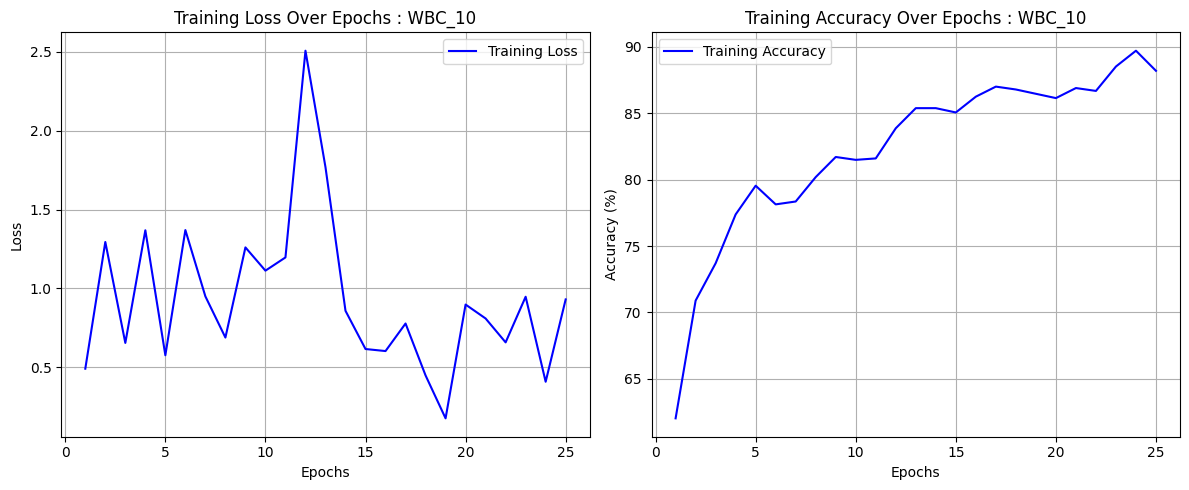

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss

epochs1 = range(1, len(train_accuracy_list) + 1)


# Create a list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
epochs = list(range(1, len(epochs1) + 1))

# Create a 2x2 grid of subplots
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs : WBC_10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)



plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_list, label='Training Accuracy', color='blue')
plt.title('Training Accuracy Over Epochs : WBC_10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

**Plotting the Validation Loss and Accuracies for WBC_1 without Pretraining**

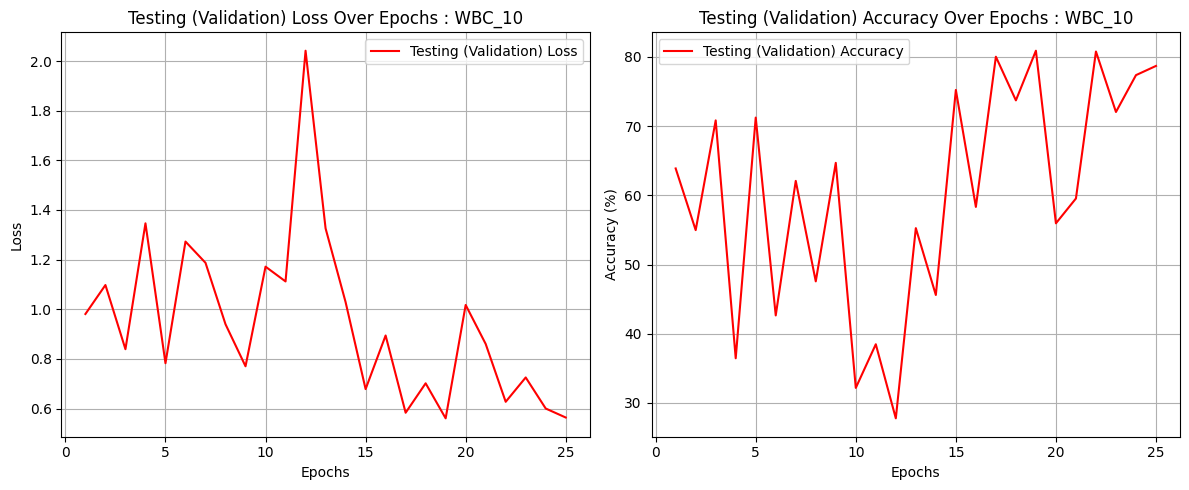

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
epochs1 = range(1, len(train_accuracy_list) + 1)

# Create a list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
epochs = list(range(1, len(epochs1) + 1))

# Create a 2x2 grid of subplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, validation_loss_list, label='Testing (Validation) Loss', color='Red')
plt.title('Testing (Validation) Loss Over Epochs : WBC_10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracy_list, label='Testing (Validation) Accuracy', color='Red')
plt.title('Testing (Validation) Accuracy Over Epochs : WBC_10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [ ]:
# Save the training loss and accuracy
with open('/content/drive/My Drive/nndlprojectdata/WBC_10/without_pretraining/training_metrics.txt', 'w') as f:
    f.write("Training Loss: " + str(train_loss_list) + "\n")
    f.write("\nTraining Accuracy: " + str(train_accuracy_list) + "\n")

# Save the validation loss and accuracy
with open('/content/drive/My Drive/nndlprojectdata/WBC_10/without_pretraining/validation_metrics.txt', 'w') as f:
    f.write("Testing (Validation) Loss: " + str(validation_loss_list) + "\n")
    f.write("\nTesting (Validation) Accuracy: " + str(validation_accuracy_list) + "\n")

**Calcualting the class-wise accuracies, F1 score and confusion matrix**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# redefining the classes used in the model
class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class NeuralNetwork(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(NeuralNetwork, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 128, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)


    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# loading the model
loaded_model = NeuralNetwork(BasicResidualBlock, [2, 2, 2]).to(device)
loaded_model.load_state_dict(torch.load('/content/drive/My Drive/nndlprojectdata/WBC_10/without_pretraining/wbc10_model_without_pretraining.pth'))
loaded_model.eval()

# Preprocess the validation dataset
validation_path = "/content/WBC/WBC_test/val/data"
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

validationset = ImageFolder(root=validation_path, transform=transform_test)

# Create the test data loader
testloader = torch.utils.data.DataLoader(validationset, batch_size=8, shuffle=False, num_workers=2)

# Initialize class-wise variables
class_correct = list(0. for _ in range(5))
class_total = list(0. for _ in range(5))
class_names = validationset.classes

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print class-wise accuracy
for i in range(5):
    print(f"Accuracy of class {class_names[i]}: {100 * class_correct[i] / class_total[i]}%")


Device: cuda:0
Accuracy of class Basophil: 100.0%
Accuracy of class Eosinophil: 25.396825396825395%
Accuracy of class Lymphocyte: 96.11650485436893%
Accuracy of class Monocyte: 44.21052631578947%
Accuracy of class Neutrophil: 80.64211520302172%


F1 score: 0.7842619063898177




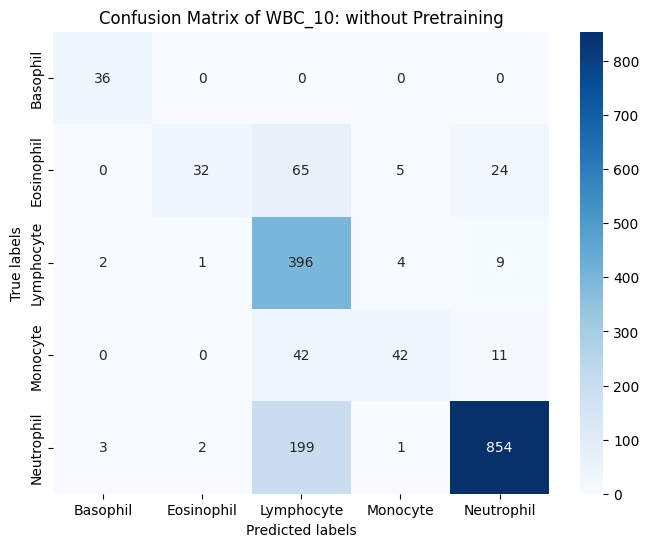

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score


true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            true_labels.append(label.cpu().numpy())
            predicted_labels.append(predicted[i].cpu().numpy())

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print(f"F1 score: {f1}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
class_names = validationset.classes
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of WBC_10: without Pretraining')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
print("\n")
plt.show()
